In [2]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import json
import warnings

import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import ticker
import flim_processing as fp
import flim_analysis as fa
import flim_geometry as fg
import flim_chemistry as fc
import flim_ui as fui
from ivium import load_ivium_file, IviumFile
import scipy.signal as sig
import scipy.optimize as optimize
from shapely import LineString, Point, MultiPoint

mass_particle_AC = 0.35e-6
radius_particle_AC = 454.5e-6
surface_area_AC = 2.6e-6
volume_AC = 39.46e-9
diff_OH = 5.270e-9
area_channel = 4e-3**2
nu_water = 1e-6
pixel_size = 9.09

In [3]:
data_folder = r"D:\[Code]\paper01\data"

In [4]:
"""FLIM data"""
flow_data = fp.open_flim(
    os.path.join(data_folder, "flow_p.npz"),
    property_modifications={"lifetime_phase": 1000, "value": 1000},
)

"""Features"""
flow_features = fg.load_features(data_folder, "flow_features.shp", "flow_features.npz")
flow_particle = [f for f in flow_features if f.name == "particle"][0]
flow_wall = [f for f in flow_features if f.name == "wall"][0]
flow_membrane = [f for f in flow_features if f.name == "membrane"][0]
flow_volume = [f for f in flow_features if f.name == "volume"][0]

extent = fa.get_extent(flow_data["value"][0], 9.09, 1e-3)
geom_extent = [
    0,
    flow_data["intensity"][0].shape[1],
    0,
    flow_data["intensity"][0].shape[0],
]

"""Open flim .json"""
with open(os.path.join(data_folder, "current.json"), "r") as file:
    flow_info = json.load(file)
flow_timestamps_flim = np.array(
    list(flow_info["FLIMIMAGE"]["TIMESTAMPS in ms"].values())
)
flow_delta_t_flim = flow_timestamps_flim[1] * 1e-3

"""Load Potential and Current data from ivium file"""
flow_ivium = IviumFile()
flow_ivium.set_path(os.path.join(data_folder, "flow_ivium1430.csv"))
flow_ivium.read_data_from_file()

"""Timestamps"""
flow_time_stamps = np.array([0, 1, 2, 3, 4, 5, 6, 7]) * 60
t_start = 5  # seconds
t_offset = 55
delta_t = 10
t_eval = flow_time_stamps + t_start + t_offset
flow_flim_frames = fp.timestamp2frame_flim(
    t_eval, flim_info=flow_info, offset_flim=-t_start
)["flim_frames"][::-1]
flows = np.array([2, 1.5, 1.2, 1, 0.8, 0.5, 0.3, 0.1])[::-1]
Res = flows / 60 * 1e-6 / area_channel * 2 * radius_particle_AC / nu_water
Sc = nu_water / diff_OH
Pes = Res * Sc

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


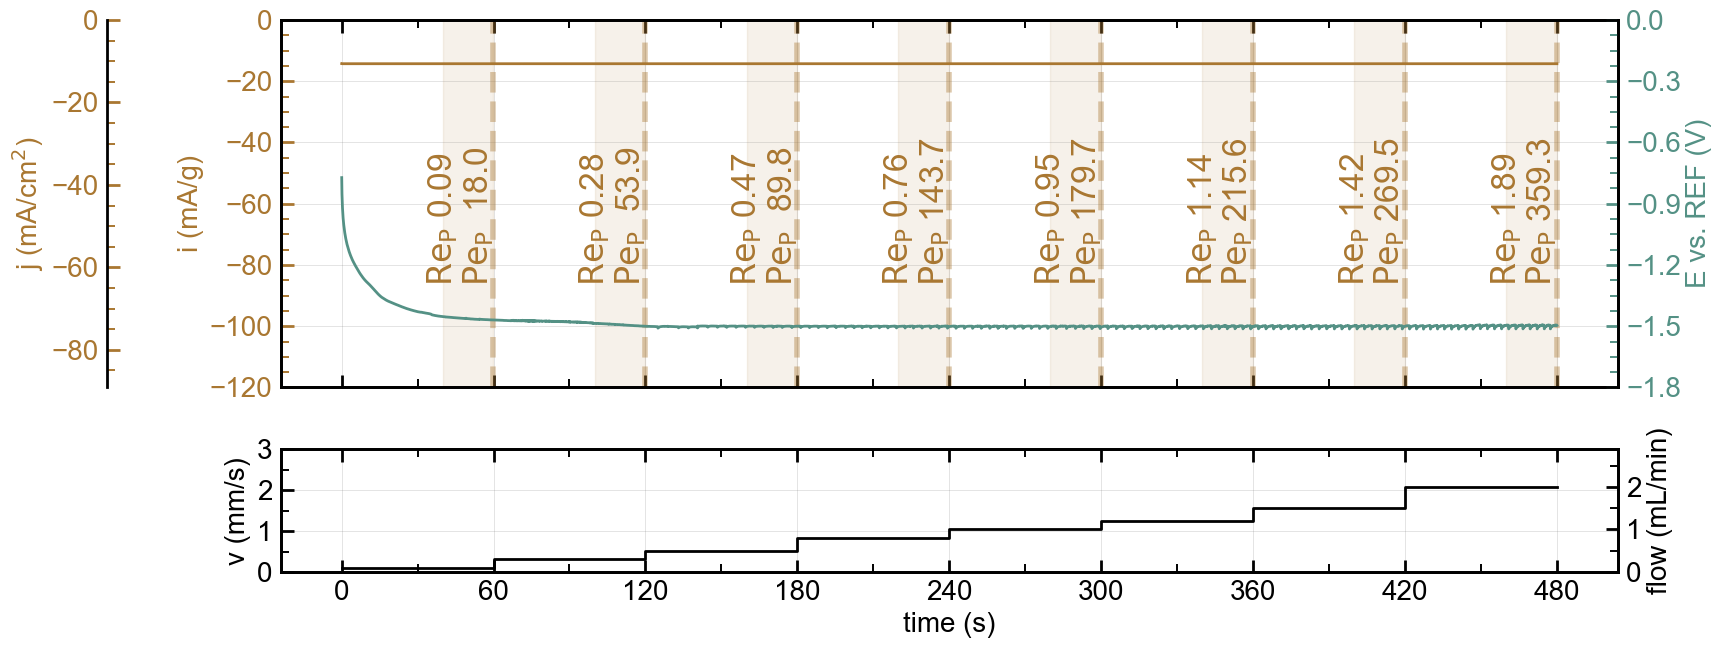

In [5]:
"""Color Map"""
cmap = plt.get_cmap("cmo.tarn")  # type:ignore
colors = cmap(np.linspace(0.25, 0.75, 2))

fig, axes = plt.subplots(
    2, 1, figsize=(17.8, 7), gridspec_kw={"height_ratios": [3, 1]}, sharex=True
)

ax = axes.ravel()[0]
ax.set_ylabel(r"i (mA/g)")

ax_ = ax.twinx()
ax_.set_ylabel("E vs. REF (V)")

ax.grid(alpha=0.3)
ax_.grid(alpha=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))


def current_specific2density(x):
    return x * surface_area_AC / mass_particle_AC * 1e3 / 1e4


def current_density2specifc(x):
    return x * surface_area_AC / mass_particle_AC


ax2 = ax.secondary_yaxis(
    -0.13, functions=(current_specific2density, current_density2specifc)
)
ax2.set_ylabel("j (mA/cm$^2$)")
ax2.yaxis.label.set_color(colors[0])  # type: ignore
ax2.tick_params(axis="y", which="both", colors=colors[0])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))  # type: ignore
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))  # type: ignore


ax.yaxis.label.set_color(colors[0])
ax.tick_params(axis="y", which="both", colors=colors[0])
ax_.yaxis.label.set_color(colors[-1])
ax_.tick_params(axis="y", which="both", colors=colors[-1])


ax.plot(flow_ivium.t, flow_ivium.I / mass_particle_AC, color=colors[0])
ax_.plot(flow_ivium.t, flow_ivium.E, color=colors[-1])

ax.set_ylim(-120, 0.0)
ax_.set_ylim(-1.8, 0.0)
ax.yaxis.set_major_locator(ticker.LinearLocator(7))
ax_.yaxis.set_major_locator(ticker.LinearLocator(7))

ax = axes.ravel()[1]
ax_ = ax.twinx()
ax_.grid(alpha=0)
ax.set_xlabel("time (s)")
ax.set_ylabel("v (mm/s)")
ax_.set_ylabel("flow (mL/min)")
ax.set_ylim(0, 3)
ax_.set_ylim(0, 3 * 60 / 1e-6 * area_channel * 1e-3)
ax.step(
    np.insert(t_eval, 0, 0),
    np.insert(flows, 0, flows[0]) / 60 * 1e-6 / area_channel * 1e3,
    color="black",
)
ax_.step(
    np.insert(t_eval, 0, 0),
    np.insert(flows, 0, flows[0]),
    color="black",
    alpha=0,
)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax_.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax_.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

for i_time, time_stamp in enumerate(t_eval):
    ax = axes.ravel()[0]
    x = flow_ivium.t[flow_ivium.t < time_stamp][-1]
    i = flow_ivium.t[flow_ivium.t < time_stamp][-1]
    s_Re = f"$Re_P$ {Res[i_time]:4.2f}\n"
    s_Pe = f"$Pe_P$ {Pes[i_time]:5.1f}"
    ymin = flow_ivium.I.min() / mass_particle_AC
    ymax = flow_ivium.I.max() / mass_particle_AC
    ax.axvline(x=x, color=colors[0], alpha=0.4, ls="--", lw=4)
    ax.axvspan(x - 20, x, alpha=0.1, color=colors[0])

    y_Re = -87
    ax.text(
        x=x + 1,
        y=y_Re,
        s=s_Re,
        rotation=90,
        horizontalalignment="right",
        verticalalignment="bottom",
        color=colors[0],
    )
    #y_Pe = -58
    ax.text(
        x=x + 1,
        y=y_Re,
        s=s_Pe,
        rotation=90,
        horizontalalignment="right",
        verticalalignment="bottom",
        color=colors[0],
    )
    ax = axes.ravel()[1]

fig.tight_layout()
fig.savefig(
    os.path.join(data_folder, "flow_EandI.png"),
    transparent=True,
)
plt.show()

In [6]:
ohminus = fc.ph2ohminus(flow_data["value"])

In [7]:
distance_end_point = 200
number_rays = 360
pulling_bearing = 5

base_points = fa.get_points_along_line_number(
    flow_particle.geometry.exterior, number_rays
)  # type:ignore
rays = fg.get_rays_of_sphere_like_base_points(base_points, pulling_bearing)

for i_ray, ray in enumerate(rays):
    ray.set_end_point_image(flow_data["intensity"][0])
    ray.set_end_point_volume(flow_volume.geometry)
    ray.set_end_point(distance_end_point)

ray_lines = []
for ray in rays:
    line = LineString([ray.base_point, ray.end_point_image])
    ray_lines.append(line)

chosen_ray_numbers = [-7, 35, 88, 172]
chosen_ray_numbers.reverse()
numerator_list = ["A", "B", "C", "D"]
chosen_rays = [rays[i] for i in chosen_ray_numbers]
v_alignments = ["center", "center", "baseline", "bottom"]
h_alignments = ["center", "center", "center", "center"]

90.0 72.37610047017682
88.99722222222222 71.74530430317861
87.99444444444444 71.59626656052103
86.99166666666666 71.09535305663087
85.9888888888889 70.36502401379477
84.98611111111111 68.95492953520335
83.98333333333333 68.08362964636297
82.98055555555555 67.45760837729716
81.97777777777777 66.8210667657832
80.975 65.97641167479208
79.97222222222223 64.28212771862758
78.96944444444445 62.33439606912441
77.96666666666667 61.18521942703751
76.96388888888889 60.52020216884239
75.96111111111111 60.707596464853
74.95833333333333 61.65298968245213
73.95555555555555 62.30522412207807
72.95277777777778 62.921956739012444
71.95 63.7813523642634
70.94722222222222 64.09243095840696
69.94444444444444 63.555053954547816
68.94166666666666 61.9686973332532
67.9388888888889 59.738829724750644
66.9361111111111 57.58066571317784
65.93333333333334 55.9103097805488
64.93055555555556 55.266913624502706
63.92777777777778 55.22038884708843
62.925 54.678937230543
61.92222222222222 53.93246291187182
60.9194444

In [36]:
rolling_window = 11
fraction_limit = 0.3
min_pixel = 10
ohminus_base = ohminus[:10].mean(axis=0)

res0s = []
for ray in rays:
    res0 = ray.get_values_along_ray(
        ohminus_base, pixel_size=pixel_size, rolling_window=rolling_window
    )
    res0s.append(res0)


flow_results = []

for i, (i_frame, time_stamp) in enumerate(zip(flow_flim_frames, flow_time_stamps)):
    mean = ohminus[i_frame - 20 : i_frame + 1].mean(axis=0)
    mean_ph = flow_data["value"][i_frame - 20 : i_frame + 1].mean(axis=0)
    # std = ohminus[i_frame-20:i_frame+1].std(axis = 0)
    flow = flows[i]
    print(i, i_frame, flow)

    ray_results = []
    for i_ray, ray in enumerate(rays):
        res = ray.get_values_along_ray(
            mean, pixel_size=pixel_size, rolling_window=rolling_window
        )
        res_ph = ray.get_values_along_ray(
            mean_ph, pixel_size=pixel_size, rolling_window=rolling_window
        )
        delta_oh_minus = res["values"] - res0s[i_ray]["values"]

        warnings.simplefilter("ignore")
        bulk_delta_oh_minus = delta_oh_minus[
            delta_oh_minus
            < (
                0.1 * (delta_oh_minus.min() + delta_oh_minus.max())
                + delta_oh_minus.min()
            )
        ].mean()
        warnings.warn("deprecated", DeprecationWarning)

        surface_delta_oh_minus = delta_oh_minus[:3].mean()
        peak_delta_oh_minus = surface_delta_oh_minus

        if i == 0:
            m = -9999
            peak = 0
            delta = 0
            peak_loc = 0
            fit_window_end = 0
        else:
            """radius of particle as benchmark"""
            benchmark_id = res["ray"][res["ray"] < radius_particle_AC * 1e6].size

            """peak detection"""
            try:
                peaks, properties = sig.find_peaks(
                    delta_oh_minus[:benchmark_id],
                    height=delta_oh_minus.max() * 0.7,
                    prominence=1e-5,
                )
                peak = peaks[np.argmax(properties["prominences"])]

                peak_delta_oh_minus = properties["peak_heights"][
                    np.argmax(properties["prominences"])
                ]
            except:
                peak = 0
                peak_delta_oh_minus = surface_delta_oh_minus

            if surface_delta_oh_minus >= peak_delta_oh_minus:
                peak = 0
                peak_delta_oh_minus = surface_delta_oh_minus

            xs = (
                res["ray"] / radius_particle_AC * 1e-6
            )  # dimensionless with particle radius
            ys = delta_oh_minus / peak_delta_oh_minus  # dimensionless y
            peak_loc = xs[peak]
            fit_window_end = peak

            """linear fit + boundary layer thickness calculation"""
            try:
                indices_below_threshold = np.where(ys[peak:] < fraction_limit)[0]
                fit_window_end = (
                    indices_below_threshold[
                        (indices_below_threshold - peak) > min_pixel
                    ][0]
                    + peak
                )
                ps, _ = optimize.curve_fit(
                    fa.linear,
                    xs[peak:fit_window_end],
                    ys[peak:fit_window_end],
                    p0=[-1, 1],
                )
                m = ps[0]
                n = ps[1]
                delta = -1 / m + peak_loc

            except ValueError as e:
                m = -9999
                peak = 0
                delta = 0
                peak_loc = 0
                fit_window_end = 0
                continue

            except IndexError as e:
                m = -9999
                peak = 0
                delta = 0
                peak_loc = 0
                fit_window_end = 0
                continue

        results = pd.Series(
            {
                "i_ray": i_ray,
                "image_angle": ray.angle,
                "flow": flow,
                "time": time_stamp,
                "count_frame": i,
                "lifa_frame": i_frame,
                "peak_id": peak,
                "fit_window_end": fit_window_end,
                "peak": peak_loc,
                "m": m,
                "delta": delta,
                "surface_delta_oh_minus": surface_delta_oh_minus,
                "surface_ph": res_ph["values"][: min_pixel // 2].mean(),
                "peak_delta_oh_minus": peak_delta_oh_minus,
                "bulk_delta_oh_minus": bulk_delta_oh_minus,
            }
        )
        ray_results.append(results)
    ray_results_frame = pd.DataFrame(ray_results)
    ray_results_frame["sigma"] = np.sqrt(
        (
            (
                ray_results_frame.delta
                - fa.rollavg_convolve_circle(ray_results_frame.delta, 31)
            )
            / fa.rollavg_convolve_circle(ray_results_frame.delta, 31)
        )
        ** 2
    )
    flow_results.append(ray_results_frame)
data = pd.concat(flow_results, ignore_index=True)
data["flow_angle"] = data.image_angle.apply(fa.angle_image2flow)
data["i_ray"] = data.i_ray.astype("int")
data["lifa_frame"] = data.lifa_frame.astype("int")
data["count_frame"] = data.count_frame.astype("int")
data["distance"] = data.delta.astype("float") * radius_particle_AC
data["time"] = data.time.astype("float")
print(data.size)
data.to_csv(os.path.join(data_folder, "flow_results.csv"))

0 484 0.1
1 424 0.3
2 364 0.5
3 304 0.8
4 245 1.0
5 185 1.2
6 125 1.5
7 65 2.0
50220


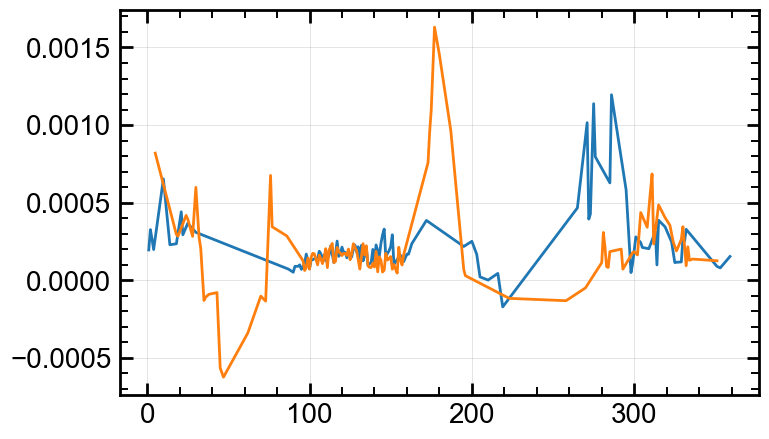

In [42]:
for i_frame_count, frame_count in enumerate(data.count_frame.unique()):
    if i_frame_count not in [4, 6]:
        continue
    d_current = data.query("(count_frame == @frame_count) & (sigma < 0.7)")
    plt.plot(d_current.i_ray, d_current.distance)

plt.show()

# Profile Extraction

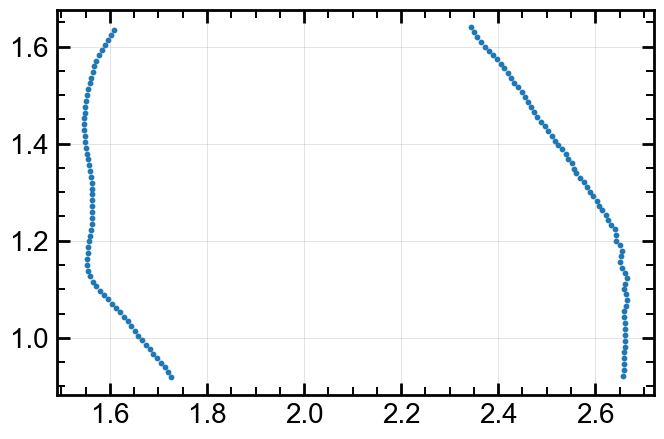

In [71]:
delta_y = 40
ymin = flow_particle.geometry.centroid.y - delta_y
ymax = flow_particle.geometry.centroid.y + delta_y
interesting_rays = [r for r in rays if ymin <= r.base_point.y <= ymax]
fig, ax = plt.subplots()
gpd.GeoSeries(
    fa.affine_transform_pixel2extent(
        MultiPoint([r.base_point for r in interesting_rays]), geom_extent, list(extent)
    )
).plot(ax=ax, markersize=10)
plt.show()

In [72]:
rolling_window = 11
min_pixel = 10
mean_base = ohminus[:10].mean(axis=0)
mean_ph_base = flow_data["value"][:10].mean(axis=0)

flow_profiles = []
for i, (i_frame, time_stamp) in enumerate(zip(flow_flim_frames, flow_time_stamps)):
    ray_results = []
    mean = (ohminus[i_frame - 20 : i_frame + 1].mean(axis=0) - mean_base) * 1e6
    mean_ph = flow_data["value"][i_frame - 20 : i_frame + 1].mean(axis=0) - mean_ph_base

    for i_ray, ray in enumerate(interesting_rays):
        res = ray.get_values_along_ray(
            mean, pixel_size=pixel_size, rolling_window=rolling_window
        )
        res_ph = ray.get_values_along_ray(
            mean_ph, pixel_size=pixel_size, rolling_window=rolling_window
        )
        ray_results.append(
            pd.DataFrame(
                {
                    "x": res["xs"],
                    "y": res["ys"],
                    "r": res["ray"],
                    "value": fa.rollavg_convolve_edges(res["values"], 11),
                    "ph": fa.rollavg_convolve_edges(res_ph["values"], 11),
                    "i_ray": i_ray,
                    "image_angle": ray.angle,
                }
            )
        )

    flow_profiles.append(pd.concat(ray_results))
    flow_profiles[-1]["i"] = i
    flow_profiles[-1]["flow"] = flows[i]
    flow_profiles[-1]["flim_frame"] = i_frame
    flow_profiles[-1]["time_stamp"] = time_stamp

flow_y_cuts = pd.concat(flow_profiles)
flow_y_cuts.to_csv(os.path.join(data_folder, "flow_profiles.csv"))

In [73]:
flow_y_cuts

,x,y,r,value,ph,i_ray,image_angle,i,flow,flim_frame,time_stamp
0,292,360,0.00,22.424612,0.944680,0,26.351080,0,0.1,484,0
1,293,361,9.09,22.215484,0.921936,0,26.351080,0,0.1,484,0
2,294,361,18.18,22.405976,0.908857,0,26.351080,0,0.1,484,0
3,294,361,27.27,22.355699,0.887995,0,26.351080,0,0.1,484,0
4,295,362,36.36,21.955561,0.862816,0,26.351080,0,0.1,484,0
...,...,...,...,...,...,...,...,...,...,...,...
156,53,436,1418.04,4.044684,0.300676,135,150.934405,7,2.0,65,420
157,52,437,1427.13,3.415013,0.305117,135,150.934405,7,2.0,65,420
158,51,437,1436.22,2.529391,0.309833,135,150.934405,7,2.0,65,420
159,50,438,1445.31,2.424643,0.332611,135,150.934405,7,2.0,65,420


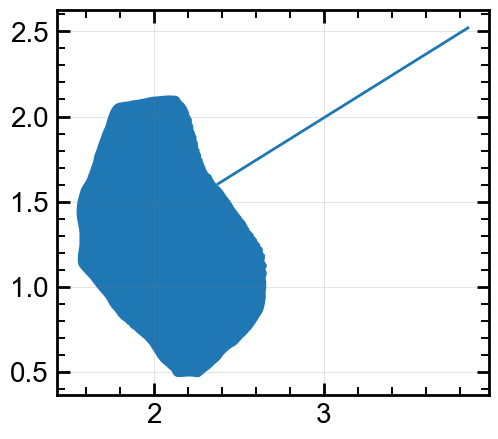

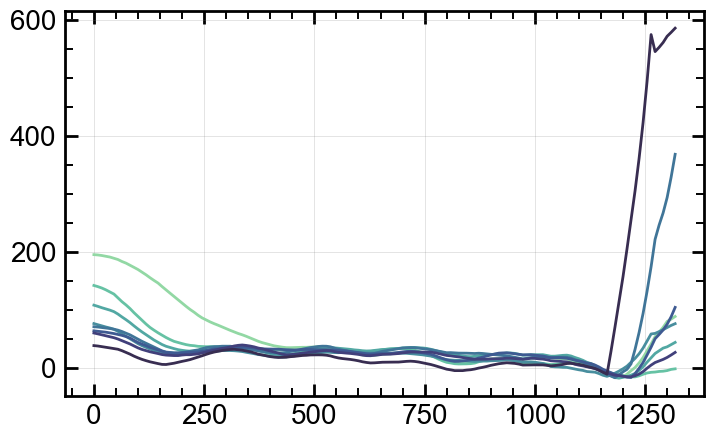

In [74]:
flow_cmap = plt.get_cmap("cmo.deep")  # type:ignore
flow_colors = list(flow_cmap(np.linspace(0.2, 0.9, len(flow_flim_frames))))

flow_ray_left = 80
flow_ray_right = 65

fig, ax = plt.subplots()
gpd.GeoSeries(
    fa.affine_transform_pixel2extent(
        interesting_rays[flow_ray_right].evaluation_line, geom_extent, list(extent)
    )
).plot(ax=ax)
#gpd.GeoSeries(
#    fa.affine_transform_pixel2extent(
#        interesting_rays[flow_ray_left].evaluation_line, geom_extent, list(extent)
#    )
#).plot(ax=ax)
gpd.GeoSeries(
    fa.affine_transform_pixel2extent(flow_particle.geometry, geom_extent, list(extent))
).plot(ax=ax)

fig, ax = plt.subplots()
for i, (i_frame, time_stamp) in enumerate(zip(flow_flim_frames, flow_time_stamps)):
    ymin_right = flow_y_cuts.query("i == @i & i_ray == @i_ray_right").min() * 0.7
    ymin_left = flow_y_cuts.query("i == @i & i_ray == @i_ray_left").min() * 0.7
    left = flow_y_cuts.query("i == @i & i_ray == @i_ray_left") - ymin_left
    right = flow_y_cuts.query("i == @i & i_ray == @i_ray_right") - ymin_right
    ax.plot(right.r, right.value, color=flow_colors[i])
    # left = flow_y_cuts.query("x < 220 & volume > 0.8 & i == @i")
    # right = flow_y_cuts.query("x > 220 & x < 350 & volume > 0.8 & i == @i")